In [1]:
# Libraries

import sys
import math
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
from datetime import datetime, timedelta

In [2]:
# Inital information

url = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-1?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
# change page numbers for these!
html = requests.get(url)
soup = bs(html.text, 'html.parser')

body = soup.find('body')
header = body.find('div', class_ = 'results-header mt-5')
property_count = int(header.find('div', class_ = 'results-message').contents[0].strip())
pages_needed = math.ceil(property_count / 24) + 1
# extra pages only include featured properties - so doesn't go past max. page index.

print(f"There are {property_count} properties on the website currently.\nSo {pages_needed} pages are needed.")

There are 69 properties on the website currently.
So 4 pages are needed.


In [3]:
# Function for getting links

def get_links(soup):
    links = []

    i = 1
    max_iterations = 30
    while len(links) < 24 and i <= max_iterations:
        elements = soup.select(f"body > div.container.mt-3 > div.results.row > div:nth-child({i}) > div.card.h-100.card--results > a")
        # Featured properties still appear elsewhere - so aren't needed. It also causes a break when an empty page is reached.

        # if not elements:
        #     elements = soup.select(f"body > div.container.mt-3 > div.results.row > div:nth-child({i}) > div.card.h-100.card--featured > a")

        if not elements:
            i += 1
            continue

        for element in elements:
            href = element['href']
            link = 'https://propertylink.estatesgazette.com'+ href
            links.append(link)
        i += 1

    return links


all_links = get_links(soup)


In [4]:
# Looping through pages

base_url = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-{}?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'

all_links = []  # Store all links from all pages

for page_num in range(1, pages_needed+1):  # Loop over the page numbers (1 to 3 in this example)
    url = base_url.format(page_num)
    html = requests.get(url)
    soup = bs(html.text, 'html.parser')
    
    page_links = get_links(soup)
    all_links.extend(page_links)  # Add the links from this page to the all_links list

    print(f"Page {page_num} has {len(page_links)} links.")

property_links = list(set(all_links)) # removing duplicates
print(f"Total links collected: {len(property_links)}")


Page 1 has 23 links.
Page 2 has 23 links.
Page 3 has 23 links.
Page 4 has 0 links.
Total links collected: 69


In [10]:
# Single property test

single_link = property_links[2]
print(single_link)

html = requests.get(single_link)
soup = bs(html.text, 'html.parser')

# soup.select('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-name')
agent_name = soup.find('div', class_='agent-name').find_all_next(string=True)[1].strip()


agency_name = soup.select_one('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-logo > img')
if agency_name == None:
    agency_name = soup.select_one('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-logo > a > img')
agency_name = agency_name['alt']

agency_name = soup.find("meta", {"name": "gwa_advertiserName"})
agency_name = agency_name.get("content")



id_tag = soup.find("meta", {"name": "gwa_contentID"})
id_tag = id_tag.get("content")

# address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(3)') # Full div
# address = address[0].get_text(strip=True) # gives address with below stuck to the front
# address = address.replace("ADDRESS", "").strip() #tidy

address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > h1')
address = address[0].get_text(strip=True)
address = address.replace("sharebookmark", "").strip() #tidy

size = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(2)')
size = size[0].get_text(strip=True) # gives size with below stuck to the front
size = size.replace("SIZE", "").strip() #tidy

type = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(4)')
type = type[0].get_text(strip=True)
type = type.replace("TYPE", "").strip()

price = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(1)')
price = price[0].get_text(strip=True)
price = price.replace("TO RENT", "").strip()

date_posted = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(6)')
date_posted = date_posted[0].get_text(strip=True)
date_posted = date_posted.replace("POSTED ON", "").strip()

desc = soup.select_one('body > div:nth-of-type(4) > div:nth-of-type(2) > div > div:nth-of-type(5) > div > div:nth-of-type(1)')
desc = desc.get_text(strip=True)

latitude = soup.find('meta', itemprop='latitude')['content']
longitude = soup.find('meta', itemprop='longitude')['content']

print(agent_name)
print(agency_name)
print(id_tag)
print(address)
print(size)
print(type)
print(price)
print(date_posted)
print(desc,'\n')
print(latitude, ',', longitude)



https://propertylink.estatesgazette.com/property-details/6979703-unit-1-and-4-the-dairy-priston-mill-farm-priston-bath-somerset-ba2-9eq
Nathan Clark
CSquared (Previously Colston & Colston Chartered Surveyors)
6979703
Unit 1 and 4 The Dairy, Priston Mill Farm, Priston, Bath, Somerset, BA2 9EQ
3,129 - 3,637 Sq Ft
General Industrial, Industrial
£24,000.00 - £27,000.00  Per  Annum
19th September 2024
DescriptionUnit 1 comprises an end of terrace industrial unit constructed with a portal frame and clad externally in stone and timber with a sheet asbestos clad roof. The unit benefits from single phase electricity, mains water, drainage, and is separately assessed for rates. Minimum eaves height of approximately 6 meters and vehicular access is provided via a up and over roller shutter door of approx. 5.5m high and 4.5m wide (currently restricted by a suspended ceiling which could possibly be removed if necessary and minor alteration to opening).Unit 4 has similar construction to Unit 1 and h

In [11]:
# Collecting all property information

def assign_value(elements, keyword):
    for element in elements:
        text = element.get_text(strip=True)
        if keyword in text:
            return text.replace(keyword, "").strip()
    return None

property_data = []

for property in property_links:
    # print(property)
    html = requests.get(property)
    soup = bs(html.text, 'html.parser')

    agent_name = soup.find('div', class_='agent-name').find_all_next(string=True)[1].strip()
    
    agency_name = soup.find("meta", {"name": "gwa_advertiserName"})
    agency_name = agency_name.get("content")

    id_tag = soup.find("meta", {"name": "gwa_contentID"})
    id_tag = id_tag.get("content")

    desc = soup.select_one('body > div:nth-of-type(4) > div:nth-of-type(2) > div > div:nth-of-type(5) > div > div:nth-of-type(1)')
    desc = desc.get_text(strip=True)

    # address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > h1')
    # address = address[0].get_text(strip=True)
    # address = address.replace("sharebookmark", "").strip() #tidy

    elements = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div')

    # Assign values based on keywords - thank you ChatGPT for this one...
    price = assign_value(elements, "TO RENT")
    size = assign_value(elements, "SIZE")
    address = assign_value(elements, "ADDRESS")
    type = assign_value(elements, "TYPE")
    # tenure = assign_value(elements, "TENURE")
    date_posted = assign_value(elements, "POSTED ON")

    latitude = soup.find('meta', itemprop='latitude')['content']
    longitude = soup.find('meta', itemprop='longitude')['content']
    

    property_data.append({
        'Id': id_tag,
        'Address': address,
        'Price': price,
        'Size': size,
        'Property Type': type,
        'Agency Name': agency_name,
        'Agent Name': agent_name,
        'Description': desc,
        'Property Link': property,
        'Date Posted': date_posted,
        'Latitude': latitude,
        'Longitude': longitude
    })

    

df = pd.DataFrame(property_data)



df.head(2)

,Id,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude
0,6898832,"Bath Street, Bath, Bath And North East Somerse...",ROA,"5,381 Sq Ft","Office, General Retail, Restaurants/Cafes, Off...",Carter Jonas LLP,Tim Brooksbank,LEASE ASSIGNMENT - Retail Unit 'E' UseThis Gra...,https://propertylink.estatesgazette.com/proper...,22nd April 2024,51.3807307,-2.3606197
1,6923560,"Upper Floors , 39 Gay Street, Bath, Bath And N...","£10,000.00 - £23,500.00 Per Annum",436 Sq Ft,"Office, Offices",CSquared (Previously Colston & Colston Charter...,Maddie Pyles,Gay Street is part of Bath's long standing eco...,https://propertylink.estatesgazette.com/proper...,12th August 2024,51.3841127,-2.3631466


In [12]:
# Writing to csv
today = datetime.now()
last_week = today - timedelta(weeks=1)
today = today.strftime("%d.%m.%y")
last_week = last_week.strftime("%d.%m.%y")
#df.to_csv(f'spreadsheets/EG_scraped_{today}.csv',index=False)

In [13]:
# Comparison w/ last week


today = datetime.now()
last_week = today - timedelta(weeks=1)
today = today.strftime("%d.%m.%y")
last_week = last_week.strftime("%d.%m.%y")
print(today)
# df_old = pd.read_csv(f'spreadsheets/EG_properties_{last_week}.csv')
df_old = pd.read_csv(f'EG_properties_11.11.24.csv')
# df_new = pd.read_csv(f'spreadsheets/EG_scraped_{today}.csv')
df_new = pd.read_csv(f'EG_scraped_18.11.24.csv')

df_old.head()

key = 'Property Link'
df_dropped = df_old[~df_old[key].isin(df_new[key])]
# df_dropped.head()
# df_dropped.to_csv('dropped_5.11.24.csv', index=False)

df_posted = df_new[~df_new[key].isin(df_old[key])]
# df_posted.info()
# df_posted.head()
# df_posted.to_csv('posted_5.11.24.csv', index=False)



df_posted['Status'] = 'Added'
df_dropped['Status'] = 'Dropped'

df_dropped.head()

df_changes = pd.concat([df_posted, df_dropped], ignore_index=True)
df_changes = df_changes[['Status'] + [ col for col in df_changes.columns if col != 'Status' ]]
df_changes.head()
df_changes.to_csv(f'changes_{today}.csv', index=False)

19.11.24


C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_27096\1000067238.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posted['Status'] = 'Added'
C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_27096\1000067238.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['Status'] = 'Dropped'


In [14]:
#Splitting Names into first and last

df_changes['Agent Name']
df_changes[['First Name', 'Last Name']] = df_changes['Agent Name'].str.split(' ', n=1, expand=True)
df_changes.head()

,Status,Id,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude,Position,Featured Status,Property Title,Agent Logo,Enquiry Link,First Name,Last Name
0,Added,6906299.0,"7 The Corridor, Bath, BA1 5AP",ROA,"1,763 Sq Ft","General Retail, Retail",Hartnell Taylor Cook LLP,Rebecca Harries,Key PointsSituated within the Grade II listed ...,https://propertylink.estatesgazette.com/proper...,13th November 2024,51.382109,-2.359783,NaN,NaN,NaN,NaN,NaN,Rebecca,Harries
1,Added,6990240.0,"2nd & 3rd Floors, Northgate House, Upper Borou...",ROA,"1 - 10,800 Sq Ft","Office, Serviced Office, Offices, Business par...",IWG Plc,IWG PLC,Being based in Bath gives your business the ku...,https://propertylink.estatesgazette.com/proper...,13th November 2024,51.382617,-2.359545,NaN,NaN,NaN,NaN,NaN,IWG,PLC
2,Dropped,NaN,"18 Kingsmead Square, Bath, Bath and North East...","£25,000.00 Per Annum","1,249 Sq Ft","Office, General Retail, Offices, Retail",NaN,Cj logo new rgb,NaN,https://propertylink.estatesgazette.com/proper...,NaN,NaN,NaN,2.0,NaN,"18 Kingsmead Square, Bath...",https://propertylinkassets.estatesgazette.com/...,https://propertylink.estatesgazette.com/commer...,Cj,logo new rgb
3,Dropped,NaN,"23 Broad Street, Bath, Bath and North East...","£13,850.00 Per Annum","1,011 Sq Ft","Office, Retail - High Street, Offices, Retail",NaN,C squared,NaN,https://propertylink.estatesgazette.com/proper...,NaN,NaN,NaN,4.0,NaN,"23 Broad Street, Bath, Bath and...",https://propertylinkassets.estatesgazette.com/...,https://propertylink.estatesgazette.com/commer...,C,squared
4,Dropped,NaN,"46 Milsom Street, Bath, Bath and North East...","£95,000.00 Per Annum","0 - 2,992 Sq Ft","General Retail, Restaurants/Cafes, Retail, Lic...",NaN,Cj logo new rgb,NaN,https://propertylink.estatesgazette.com/proper...,NaN,NaN,NaN,11.0,NaN,"46 Milsom Street, Bath, Bath...",https://propertylinkassets.estatesgazette.com/...,https://propertylink.estatesgazette.com/commer...,Cj,logo new rgb


In [ ]:
# Email draft


# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 100)
index = 0
email_body = f"""Hi {df_changes.iloc[index]['First Name']},\n 
I see that {df_changes.iloc[index]['Address']} has been taken off the wesbites. Please could you let me know the tenant, rent and lease length?\n
Thanks,\n
[Name]"""

my_email = ''
my_password = ''


print(email_body)

print(f"\n\n\n {df_changes.iloc[index]}")
# How do I get this to send itself... do I need admin access 

Hi Rebecca,
 
I see that 7 The Corridor, Bath, BA1 5AP has been taken off the wesbites. Please could you let me know the tenant, rent and lease length?

Thanks,

[Name]



 Status                                                                                                           Added
Id                                                                                                           6906299.0
Address                                                                                  7 The Corridor, Bath, BA1 5AP
Price                                                                                                              ROA
Size                                                                                                       1,763 Sq Ft
Property Type                                                                                   General Retail, Retail
Agency Name                                                                                   Hartnell Taylor Coo

In [16]:
# Making the map

import folium
map = folium.Map(location=(51.38, -2.36), zoom_start=10)#location - the center of the map, zoom_start - the resolution
for index, row in df.iterrows():
    folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        popup=row['Address']
    ).add_to(map)
# map # unhash this to get map

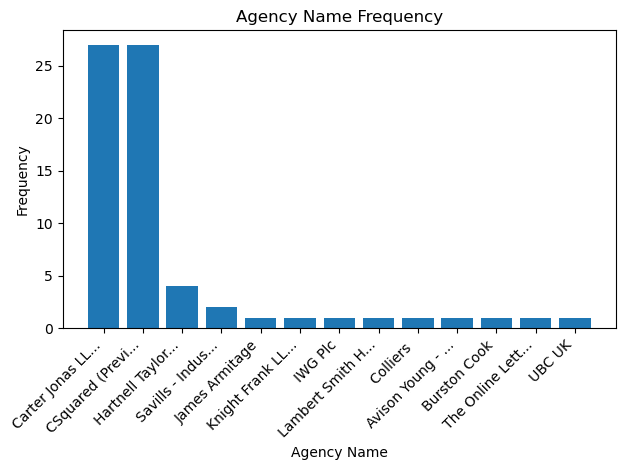

In [41]:
import matplotlib.pyplot as plt

max_length = 15  # Adjust this value as needed

# Count occurrences of each unique category in 'Agency Name'
counts = df_new['Agency Name'].value_counts()

# Count occurrences of each unique category in 'Agency Name'
categories = df_new['Agency Name'].value_counts().index  # Unique categories
values = df_new['Agency Name'].value_counts().values     # Corresponding counts


categories = [name[:max_length] + '...' if len(name) > max_length else name for name in counts.index]
# Create a bar chart
plt.bar(categories, values)

# Add title and labels
plt.title('Agency Name Frequency')
plt.xlabel('Agency Name')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
